### Import Libraries

Import necessary libraries

In [12]:
import glob
import os
import librosa
import librosa.display
import time
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import noisereduce as nr
import matplotlib.pyplot as plt
from matplotlib import cm
import skimage.io
import re
import pathlib
from IPython.display import display, Image
# %matplotlib inline
from sklearn.model_selection import train_test_split
from pydub import AudioSegment
from pydub.effects import normalize

In [13]:
RATE = 16000
TOP_DB = 25
HOP_LEGTH = 512
FRAME_SIZE = 2048
DPI = 96

# Preprocess steps
1. Load audio file
2. Trim leading and trailing silence
3. Noise reduction
4. Normalize

In [14]:
def audiosegment_to_librosawav(audiosegment):    
    channel_sounds = audiosegment.split_to_mono()
    samples = [s.get_array_of_samples() for s in channel_sounds]

    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(samples[0].typecode).max
    fp_arr = fp_arr.reshape(-1)

    return fp_arr


def librosa_to_audiosegment(filename):
    y, sr = librosa.load(filename, sr=RATE)
    y, _ = librosa.effects.trim(y, top_db=TOP_DB) # trim leading and trailing silence
    y = nr.reduce_noise(y, sr=sr) # noise reduction
    # convert from float to uint16
    y = np.array(y * (1<<15), dtype=np.int16)
    audio_segment = AudioSegment(
        y.tobytes(), 
        frame_rate=sr,
        sample_width=y.dtype.itemsize, 
        channels=1
    )
    return audio_segment

def preprocess(filename):
    audio = librosa_to_audiosegment(filename)
    audio = normalize(audio)
    audio = audiosegment_to_librosawav(audio)
    return audio

In [15]:
def stft(data):
    data = np.abs(librosa.stft(data, hop_length=HOP_LEGTH, n_fft=FRAME_SIZE))
    return librosa.power_to_db(data, ref=np.max)

def chroma(data):
    data = stft(data)
    return librosa.feature.chroma_stft(S=stft, sr=RATE)

def mel(data):
    mels = librosa.feature.melspectrogram(y=data, sr=RATE)
    return librosa.power_to_db(mels, ref=np.max)

def mfcc(data):
    return librosa.feature.mfcc(y=data, sr=RATE, n_mfcc=13, n_fft=FRAME_SIZE, hop_length=HOP_LEGTH)

In [16]:
def create_images_from_feature(df: pd.DataFrame, op, dim, aug=False):

    _fig, ax = plt.subplots(1, figsize=(dim, dim))
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # audio = preprocess(row['File_Path'])
        try:
            audio, sr = librosa.load(row['File_Path'], sr=RATE)
            audio, _ = librosa.effects.trim(audio, top_db=TOP_DB)
            # audio = nr.reduce_noise(audio, sr=sr)
            data = mfcc(audio)
            emo = row['Emotion']
        except:
            print('Skipped:', row['File_Path'])
            continue

        image = librosa.display.specshow(data, ax=ax, sr=RATE, y_axis='linear')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        plt.jet()
        _fig.savefig(f'{op}/{emo}_{i}.png')
        plt.cla()
    plt.close(_fig)
    plt.close("all")

# Building Dataframe

In [17]:
Crema_Path='../Datasets/Crema/'
Ravdess_Path='../Datasets/Ravdess/'
Savee_Path='../Datasets/Savee/'
Tess_Path='../Datasets/Tess/'

In [18]:
crema=[]
for wav in os.listdir(Crema_Path):
    emotion=wav.partition(".wav")[0].split('_')
    if emotion[2]=='SAD':
        crema.append(('sad',Crema_Path+'/'+wav))
    elif emotion[2]=='ANG':
        crema.append(('angry',Crema_Path+'/'+wav))
    elif emotion[2]=='DIS':
        crema.append(('disgust',Crema_Path+'/'+wav))
    elif emotion[2]=='FEA':
        crema.append(('fear',Crema_Path+'/'+wav))
    elif emotion[2]=='HAP':
        crema.append(('happy',Crema_Path+'/'+wav))
    elif emotion[2]=='NEU':
        crema.append(('neutral',Crema_Path+'/'+wav))
    else:
        crema.append(('unknown',Crema_Path+'/'+wav))
Crema_df=pd.DataFrame.from_dict(crema)
Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Crema_df.head()

,Emotion,File_Path
0,angry,../Datasets/Crema//1001_DFA_ANG_XX.wav
1,disgust,../Datasets/Crema//1001_DFA_DIS_XX.wav
2,fear,../Datasets/Crema//1001_DFA_FEA_XX.wav
3,happy,../Datasets/Crema//1001_DFA_HAP_XX.wav
4,neutral,../Datasets/Crema//1001_DFA_NEU_XX.wav


In [19]:
ravdess=[]
for directory in os.listdir(Ravdess_Path):
    actors=os.listdir(os.path.join(Ravdess_Path,directory))
    for wav in actors:
        emotion=wav.partition('.wav')[0].split('-')
        emotion_number=int(emotion[2])
        ravdess.append((emotion_number,os.path.join(Ravdess_Path,directory,wav)))
Ravdess_df=pd.DataFrame.from_dict(ravdess)
Ravdess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Ravdess_df['Emotion'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'},inplace=True)
Ravdess_df.head()

,Emotion,File_Path
0,neutral,../Datasets/Ravdess/Actor_01\03-01-01-01-01-01...
1,neutral,../Datasets/Ravdess/Actor_01\03-01-01-01-01-02...
2,neutral,../Datasets/Ravdess/Actor_01\03-01-01-01-02-01...
3,neutral,../Datasets/Ravdess/Actor_01\03-01-01-01-02-02...
4,neutral,../Datasets/Ravdess/Actor_01\03-01-02-01-01-01...


In [20]:
savee=[]
for wav in os.listdir(Savee_Path):
    emo=wav.partition('.wav')[0].split('_')[1].replace(r'[0-9]','')
    emotion=re.split(r'[0-9]',emo)[0]
    if emotion=='a':
        savee.append(('angry',Savee_Path+'/'+wav))
    elif emotion=='d':
        savee.append(('disgust',Savee_Path+'/'+wav))
    elif emotion=='f':
        savee.append(('fear',Savee_Path+'/'+wav))
    elif emotion=='h':
        savee.append(('happy',Savee_Path+'/'+wav))
    elif emotion=='n':
        savee.append(('neutral',Savee_Path+'/'+wav))
    elif emotion=='sa':
        savee.append(('sad',Savee_Path+'/'+wav))
    elif emotion=='su':
        savee.append(('surprise',Savee_Path+'/'+wav))
Savee_df=pd.DataFrame.from_dict(savee)
Savee_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Savee_df.head()

,Emotion,File_Path
0,angry,../Datasets/Savee//DC_a01.wav
1,angry,../Datasets/Savee//DC_a02.wav
2,angry,../Datasets/Savee//DC_a03.wav
3,angry,../Datasets/Savee//DC_a04.wav
4,angry,../Datasets/Savee//DC_a05.wav


In [21]:
tess=[]
for directory in os.listdir(Tess_Path):
    for wav in os.listdir(os.path.join(Tess_Path,directory)):
        emotion=wav.partition('.wav')[0].split('_')
        if emotion[2]=='ps':
            tess.append(('surprise',os.path.join(Tess_Path,directory,wav)))
        else:
            tess.append((emotion[2],os.path.join(Tess_Path,directory,wav)))
Tess_df=pd.DataFrame.from_dict(tess)
Tess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Tess_df.head()

,Emotion,File_Path
0,angry,../Datasets/Tess/OAF_angry\OAF_back_angry.wav
1,angry,../Datasets/Tess/OAF_angry\OAF_bar_angry.wav
2,angry,../Datasets/Tess/OAF_angry\OAF_base_angry.wav
3,angry,../Datasets/Tess/OAF_angry\OAF_bath_angry.wav
4,angry,../Datasets/Tess/OAF_angry\OAF_bean_angry.wav


In [22]:
main_df=pd.concat([Crema_df,Ravdess_df,Savee_df,Tess_df],axis=0)
main_df.shape

(12162, 2)

In [23]:
main_df.head(15)

,Emotion,File_Path
0,angry,../Datasets/Crema//1001_DFA_ANG_XX.wav
1,disgust,../Datasets/Crema//1001_DFA_DIS_XX.wav
2,fear,../Datasets/Crema//1001_DFA_FEA_XX.wav
3,happy,../Datasets/Crema//1001_DFA_HAP_XX.wav
4,neutral,../Datasets/Crema//1001_DFA_NEU_XX.wav
5,sad,../Datasets/Crema//1001_DFA_SAD_XX.wav
6,angry,../Datasets/Crema//1001_IEO_ANG_HI.wav
7,angry,../Datasets/Crema//1001_IEO_ANG_LO.wav
8,angry,../Datasets/Crema//1001_IEO_ANG_MD.wav
9,disgust,../Datasets/Crema//1001_IEO_DIS_HI.wav


In [24]:
main_df = main_df[main_df['Emotion'] != 'surprise']

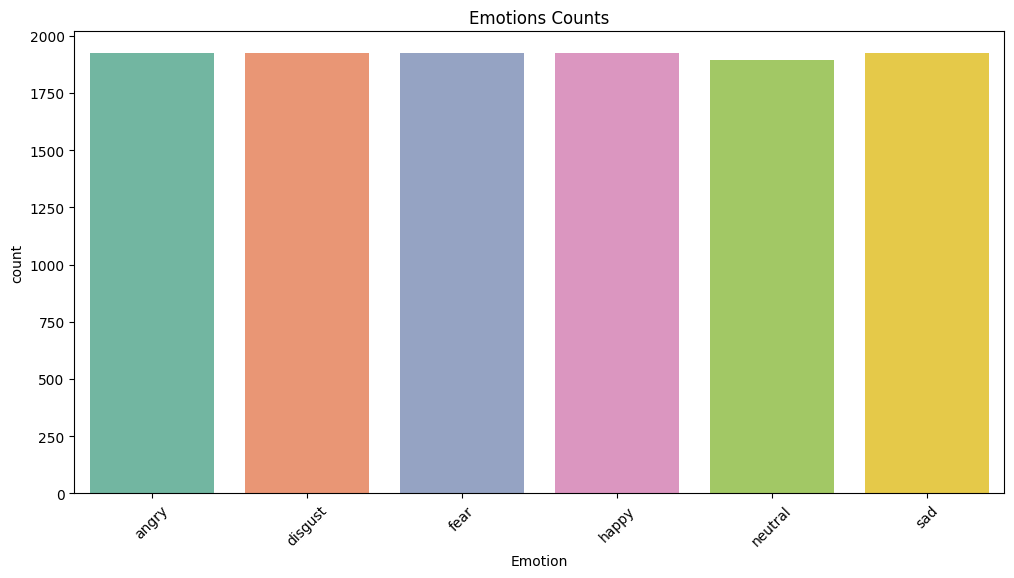

In [25]:
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=main_df,palette='Set2')
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)
plt.show()

# Splitting Dataset

In [26]:
def split_df(df: pd.DataFrame, ratio_train=0.7, ratio_val=0.15, ratio_test=0.15):
    if ratio_train + ratio_val + ratio_test != 1:
        raise ValueError('Train, validation and test ratios must sum to 1')

    # Produces test split.
    remaining, test = train_test_split(
        df, test_size=ratio_test, stratify=df['Emotion'], shuffle=True)

    # Adjusts val ratio, w.r.t. remaining dataset.
    ratio_remaining = 1 - ratio_test
    ratio_val_adjusted = ratio_val / ratio_remaining

    # Produces train and val splits.
    train, val = train_test_split(
        remaining, test_size=ratio_val_adjusted, stratify=remaining['Emotion'], shuffle=True)
    
    return train, val, test

In [27]:
train, val, test = split_df(main_df)

In [28]:
train['Emotion'].value_counts()

happy      1346
angry      1346
fear       1346
sad        1346
disgust    1345
neutral    1327
Name: Emotion, dtype: int64

In [29]:
val['Emotion'].value_counts()

disgust    289
sad        289
fear       289
angry      288
happy      288
neutral    284
Name: Emotion, dtype: int64

In [30]:
test['Emotion'].value_counts()

disgust    289
angry      289
happy      289
sad        288
fear       288
neutral    284
Name: Emotion, dtype: int64

# Generating Images

In [31]:
tech = 'mfcc_trim'

dim = 3

pathlib.Path(f'./features/images/{tech}_{dim*72}x{dim*72}').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'./features/images/{tech}_{dim*72}x{dim*72}/train').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'./features/images/{tech}_{dim*72}x{dim*72}/val').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'./features/images/{tech}_{dim*72}x{dim*72}/test').mkdir(parents=True, exist_ok=True)

train_folder = f'./features/images/{tech}_{dim*72}x{dim*72}/train'
val_folder = f'./features/images/{tech}_{dim*72}x{dim*72}/val'
test_folder = f'./features/images/{tech}_{dim*72}x{dim*72}/test'

In [32]:
create_images_from_feature(train, train_folder, dim)
create_images_from_feature(val, val_folder, dim)
create_images_from_feature(test, test_folder, dim)

100%|██████████| 1727/1727 [02:15<00:00, 12.70it/s]
